# Project: Pressure sensor placement for leakage detection

### Introduction

(This notebook is based on the epyt-flow tutorial for leakage detection found here: [Tutorials](https://github.com/WaterFutures/EPyT-and-EPyT-Flow-Tutorial))

**Authors:** Timo Beckmann, Tobias Kroecker, Yasmine Marzouk

This notebook documents a research project focused on evaluating two critical aspects of leakage detection in water distribution networks:

1. **Sensor Placement Strategy**: We implement and evaluate a sensor placement algorithm based on information theory. This approach aims to optimize the placement of pressure sensors by maximizing relevance and minimizing redundancy, ensuring effective network coverage. The evaluation includes varying the number of sensors to analyze the impact of sensor density on detection performance.

2. **Leakage Detection Method**: A machine learning-based leakage detection approach is implemented using a bagging classifier with decision trees. This method leverages ensemble learning to enhance robustness and accuracy in detecting anomalies such as leakages in the network.

3. **Datasets**: 
    - **LeakDB**: A benchmark dataset providing realistic scenarios for leakage detection in water distribution networks, used to evaluate both the sensor placement strategy and the leakage detection method.
    - **BattLeDIM**: A dataset offering realistic demand patterns and scenarios, used to simulate and validate the sensor placement strategy.

4. **Evaluation Goals**: The primary objective is to assess the performance of the leakage detection method and the effectiveness of the sensor placement strategy. This includes:
    - Analyzing the detection accuracy of the machine learning model.
    - Investigating the influence of different sensor placement sizes on detection performance.

By combining theoretical insights from information theory and machine learning with practical applications, this notebook provides a comprehensive evaluation of the interplay between sensor placement and leakage detection in water distribution networks.

## Imports and method definitions

### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ImportWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import epyt_flow
import pandas as pd
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from epyt_flow.data.networks import load_ltown
from epyt_flow.data.benchmarks import load_leakdb_scenarios
from epyt_flow.data.benchmarks.battledim import load_scenario, load_data, load_scada_data
from epyt_flow.simulation import ScenarioSimulator
from epyt_flow.simulation.events import AbruptLeakage, IncipientLeakage
from epyt_flow.utils import to_seconds, time_points_to_one_hot_encoding
from epyt_control.signal_processing import SensorInterpolationDetector
from joblib import Parallel, delayed, parallel_backend

### Implementation of the sensor placement algorithm

In [2]:
# Assume that we know which specific nodes we want to watch:
def calc_Relevance (node_pressures, relevant_index):
    relevances = {}
    for i in range(len(node_pressures)):
        relevances[i] = mutual_info_score(node_pressures[relevant_index], node_pressures[i])
    return relevances

# calcuate relevance over all nodes:

def calc_Relevances (node_pressures):
    relevances = {}
    for i in range(len(node_pressures)):
        for j in range(i + 1, len(node_pressures)):
            m_i_score = mutual_info_score(node_pressures[i], node_pressures[j])
            if i not in relevances:
                relevances[i] = m_i_score
            else:
                relevances[i] += m_i_score
            if j not in relevances:
                relevances[j] = m_i_score
            else:
                relevances[j] += m_i_score
    return relevances
    
def calc_Redundance (x_pressures, sensor_pressures):
    redundancy = 0
    for pressure in sensor_pressures:
        redundancy += mutual_info_score(x_pressures, pressure)
    redundancy /= len(sensor_pressures)
    return redundancy

In [3]:
def calc_Relevances_parallel(node_pressures, n_jobs=1):
    relevances = Parallel(n_jobs=n_jobs)(delayed(calc_Relevance)(node_pressures, i) for i in range(len(node_pressures)))
    return {i: sum(relevance[i] for relevance in relevances) for i in range(len(node_pressures))}

In [4]:
def calc_sensor_placement(node_pressures, num_sensors = 15): # do we know which nodes we want to monitor? junctions? all of them?
    remaining_nodes = list(range(len(node_pressures)))
    relevances = calc_Relevances(node_pressures)  # Assume we want to know the relevances in regard to all nodes
    Sensor_placement = [max(relevances, key=relevances.get)]
    remaining_nodes.remove(Sensor_placement[-1])
    sensor_pressures = [node_pressures[Sensor_placement[-1]]]
    no_redundance_nodes = [a for a in remaining_nodes if calc_Redundance(node_pressures[a], node_pressures[Sensor_placement]) == 0]
    while no_redundance_nodes: # add nodes of highest relevance without any redundance
        if (len(Sensor_placement) >= num_sensors):
            break
        tmp_relevances = relevances.copy()
        for i in range(len(tmp_relevances.keys())): # remove nodes that have been added to the sensors and nodes with redundance
            if i in Sensor_placement:
                del tmp_relevances[i]
                continue
            if i not in no_redundance_nodes:
                del tmp_relevances[i]
        Sensor_placement.append(max(tmp_relevances, key=relevances.get))
        remaining_nodes.remove(Sensor_placement[-1])
        sensor_pressures.append(node_pressures[Sensor_placement[-1]])
        no_redundance_nodes = [a for a in remaining_nodes if calc_Redundance(node_pressures[a], sensor_pressures) == 0]
    remaining_relevances = list(map(relevances.get, remaining_nodes))
    while not(all(list(map(lambda x: x == 0, remaining_relevances)))) and remaining_nodes:
        if (len(Sensor_placement) >= num_sensors):
            break
        RRI = {}
        for i in remaining_nodes:
            RRI[i] = relevances[i]/ calc_Redundance(node_pressures[i], sensor_pressures)
        Sensor_placement.append(max(RRI, key=RRI.get))
        sensor_pressures.append(node_pressures[Sensor_placement[-1]])
        remaining_nodes.remove(Sensor_placement[-1])
        remaining_relevances = list(map(relevances.get, remaining_nodes))
    return Sensor_placement

In [5]:
def calc_sensor_placement_parallel(node_pressures, num_sensors = 15, n_jobs = 1): # do we know which nodes we want to monitor? junctions? all of them?
    remaining_nodes = list(range(len(node_pressures)))
    if n_jobs > 1:
        relevances = calc_Relevances_parallel(node_pressures, n_jobs=n_jobs)
    else:
        relevances = calc_Relevances(node_pressures)  # Assume we want to know the relevances in regard to all nodes
    Sensor_placement = [max(relevances, key=relevances.get)]
    remaining_nodes.remove(Sensor_placement[-1])
    sensor_pressures = [node_pressures[Sensor_placement[-1]]]
    Redundances = Parallel(n_jobs=n_jobs)(delayed(calc_Redundance)(node_pressures[a], node_pressures[Sensor_placement]) for a in remaining_nodes)
    no_redundance_nodes = [remaining_nodes[a] for a in range(len(remaining_nodes)) if Redundances[a] == 0]
    while no_redundance_nodes: # add nodes of highest relevance without any redundance
        if (len(Sensor_placement) >= num_sensors):
            break
        tmp_relevances = relevances.copy()
        for i in range(len(tmp_relevances.keys())): # remove nodes that have been added to the sensors and nodes with redundance
            if i in Sensor_placement:
                del tmp_relevances[i]
                continue
            if i not in no_redundance_nodes:
                del tmp_relevances[i]
        Sensor_placement.append(max(tmp_relevances, key=relevances.get))
        remaining_nodes.remove(Sensor_placement[-1])
        sensor_pressures.append(node_pressures[Sensor_placement[-1]])
        Redundances = Parallel(n_jobs=n_jobs)(delayed(calc_Redundance)(node_pressures[a], node_pressures[Sensor_placement]) for a in remaining_nodes)
        no_redundance_nodes = [remaining_nodes[a] for a in range(len(remaining_nodes)) if Redundances[a] == 0]
    remaining_relevances = list(map(relevances.get, remaining_nodes))
    while not(all(list(map(lambda x: x == 0, remaining_relevances)))) and remaining_nodes:
        if (len(Sensor_placement) >= num_sensors):
            break
        RRI = {}
        for i in remaining_nodes:
            RRI[i] = relevances[i]/ calc_Redundance(node_pressures[i], sensor_pressures)
        Sensor_placement.append(max(RRI, key=RRI.get))
        sensor_pressures.append(node_pressures[Sensor_placement[-1]])
        remaining_nodes.remove(Sensor_placement[-1])
        remaining_relevances = list(map(relevances.get, remaining_nodes))
    return Sensor_placement

### Implementation of the bagging classifier

In [ ]:
# DecisionTreeClassifier with entropy criterion is in the ID3 style. Classifier architecture is based on the RDTBC-SFLO paper (https://www.researchgate.net/publication/333681237_Random_Bagging_Classifier_and_Shuffled_Frog_Leaping_Based_Optimal_Sensor_Placement_for_Leakage_Detection_in_WDS)
def mixed_model_classification_fit(n_estimators, X_train, y_train, n_jobs=1):
    with parallel_backend('threading', n_jobs=n_jobs):
        base = DecisionTreeClassifier(
            criterion='entropy',
            class_weight='balanced', 
            max_depth=5,
            max_features='sqrt',
            min_samples_leaf=5,
            min_samples_split=10,
            random_state=42
            )
        bagged = BaggingClassifier( #for faster runtime adjust parameters, especially n_estimators. n_jobs greatly improves runtime if set to a higher value
            estimator=base, 
            n_estimators=n_estimators, 
            max_samples=0.8,
            max_features=0.8,
            bootstrap=True, 
            oob_score=True
            ) 
        bagged.fit(X_train, y_train)
    return bagged

def mixed_model_classification_predict(classifier, X_test, y_test, n_jobs=1, print_report=False):
    with parallel_backend('threading', n_jobs=n_jobs):
        y_pred = classifier.predict(X_test)
    if print_report:
        print(classification_report(y_test, y_pred, labels=np.unique(y_test),
                                    target_names=[f"class_{int(c)}" for c in np.unique(y_test)], output_dict=True))
    return y_pred


### Metrics

In [ ]:
def evaluate_and_collect(clf, X_test, y_test, verbose=False):
    if verbose:
        y_pred = mixed_model_classification_predict(clf, X_test, y_test, print_report=True)
    else:
        y_pred = mixed_model_classification_predict(clf, X_test, y_test, print_report=False)
    rpt = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    probabilities = clf.predict_proba(X_test)
    uniq = np.unique(y_test)
    if len(uniq) == 2:
        ll  = log_loss(y_test, probabilities)
        rc = roc_auc_score(y_test, probabilities[:,1])
    else:
        ll  = np.nan
        rc = np.nan
    df = pd.DataFrame(rpt).T[['precision','recall','f1-score']]
    df.loc['roc_auc', :] = [rc, pd.NA, pd.NA]
    df.loc['log_loss', :] = [ll, pd.NA, pd.NA]
    return y_pred, df

### Minor tests of the classifier. Only used for quick evaluation and can be removed later if wanted

In [ ]:
data_dict = epyt_flow.data.benchmarks.leakdb.load_data(
    #scenarios_id=["1", "2", "3", "4", "5"],  
    scenarios_id=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"],  
    #scenarios_id=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"],
    use_net1=False,
    return_X_y=True
)

X_list, y_list = [], [] 
for sid, (Xi, yi) in data_dict.items():
    X_list.append(Xi.values if hasattr(Xi, "values") else Xi) #Check for correctness. 
    y_list.append(yi)

X_dummy = np.vstack(X_list)
y_dummy = np.concatenate(y_list)

print(f"Total samples: {X_dummy.shape[0]}, features: {X_dummy.shape[1]}")

X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split( #Might use datasets given train-test split
    X_dummy, y_dummy,
    test_size=0.20,
    random_state=42,
    stratify=y_dummy
)

clf = mixed_model_classification_fit(100, X_train_dummy, y_train_dummy, n_jobs=8)

Total samples: 175200, features: 66


In [177]:
sda = mixed_model_classification_predict(clf, X_test_dummy, y_test_dummy)

{'class_0': {'precision': 0.8481325748206777, 'recall': 0.9999270977619013, 'f1-score': 0.9177958446251129, 'support': 27434.0}, 'class_1': {'precision': 0.9992581602373887, 'recall': 0.35419405732316595, 'f1-score': 0.5230052417006407, 'support': 7606.0}, 'accuracy': 0.8597602739726027, 'macro avg': {'precision': 0.9236953675290331, 'recall': 0.6770605775425336, 'f1-score': 0.7204005431628768, 'support': 35040.0}, 'weighted avg': {'precision': 0.8809368328880152, 'recall': 0.8597602739726027, 'f1-score': 0.8321001446866558, 'support': 35040.0}}


In [ ]:
X20, y20 = epyt_flow.data.benchmarks.leakdb.load_data(
    scenarios_id=["30"],
    use_net1=False,
    return_X_y=True
)["30"]

X20 = getattr(X20, "values", X20)

y20_pred = mixed_model_classification_predict(clf, X20, y20, n_jobs=4, print_report=True)

{'class_0': {'precision': 0.7071917808219178, 'recall': 1.0, 'f1-score': 0.8284854563691073, 'support': 12390.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5130.0}, 'accuracy': 0.7071917808219178, 'macro avg': {'precision': 0.3535958904109589, 'recall': 0.5, 'f1-score': 0.41424272818455365, 'support': 17520.0}, 'weighted avg': {'precision': 0.5001202148620755, 'recall': 0.7071917808219178, 'f1-score': 0.5858981052747283, 'support': 17520.0}}


## LeakDB

###  Loading scenarios and placing sensors

In this part a subset of the scenarios from LeakDB is loaded and based on existiong pressure data from the different scenarios, the sensor placements are calculated. The scenarios are split into a train and a testset, based on their ids. The pressure sensors are placed based on the training data, assuming that in a realistic scenario the sensors could only be placed based on a finite set of pressure data.

In [ ]:
#NOTE: this approach calculates a sensor placement based on multiple scenarios, i.e. all scenarios we look at
#      due to the complexity of the algorithm this will take a lot of time!
scen_train_keys = [str(num) for num in random.sample(range(1, 901), 800)]
scen_test_keys = ["911", "912", "913", "914", "915", "916", "917", "918", "919", "920"]
scen_keys = scen_train_keys + scen_test_keys
data = epyt_flow.data.benchmarks.leakdb.load_data(scenarios_id=scen_train_keys, use_net1=False, return_X_y=False)

pressure_column_heads = data[scen_train_keys[0]].columns[:32]
node_pressures = []
for key in scen_train_keys:
    for i in range(len(pressure_column_heads)):
        if key == scen_train_keys[0]:
            node_pressures.append(data[key]['Pressure-Node_' + str(i + 1)])
        else:
            node_pressures[i] = np.concatenate((node_pressures[i], data[key]['Pressure-Node_' + str(i + 1)]))
node_pressures = np.array(node_pressures)
node_pressures.shape

/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-414.zip: 100%|###############################################################| 8.72M/8.72M [00:01<00:00, 5.63MB/s]
/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-168.zip: 100%|###############################################################| 8.62M/8.62M [00:01<00:00, 6.83MB/s]
/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-330.zip: 100%|###############################################################| 8.68M/8.68M [00:01<00:00, 6.52MB/s]
/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-76.zip: 100%|################################################################| 8.65M/8.65M [00:01<00:00, 6.95MB/s]
/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-461.zip: 100%|###############################################################| 8.51M/8.51M [00:01<00:00, 5.54MB/s]
/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-636.zip: 100%|###########################

(32, 14016000)

In [8]:
sensor_placements = calc_sensor_placement_parallel(node_pressures, num_sensors=15, n_jobs=8)
print("Sensor placements:", sensor_placements)

/opt/homebrew/Caskroom/miniconda/base/envs/ML_WD/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ML_WD/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ML_WD/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/ML_WD/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:58: UserWarning: Clustering metrics e

Sensor placements: [29, 0, 1, 8, 2, 14, 22, 5, 25, 20, 17, 11, 27, 4, 16]


In [9]:
# we can use the results from the bigger list of sensor placements to create a smaller list
sensor_placements_5 = sensor_placements[:5]

In [10]:
sensor_placements_10 = sensor_placements[:10]

In [11]:
configs = load_leakdb_scenarios(scenarios_id=scen_keys, use_net1=False, verbose=True)
scenarios = {}
for i, key in enumerate(scen_keys):
    scenarios[key] = ScenarioSimulator(scenario_config=configs[i])

The topology of the water distribution network does not change between the different scenarios. Here the general topology is inspected.

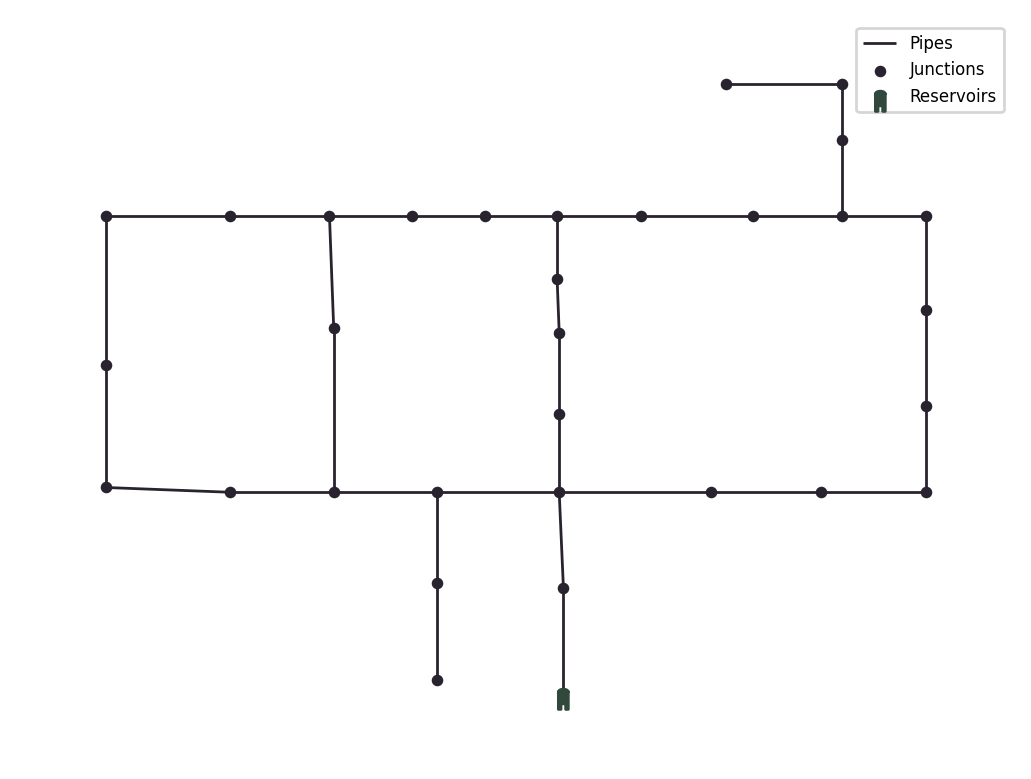

In [12]:
scenarios[scen_train_keys[0]].plot_topology()

Run the complete set of simulations:

In [13]:
scada_data = {}
for key, scenario in scenarios.items():
    scada_data[key] = scenario.run_simulation(verbose=True)

Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3063.23it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3025.54it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3080.17it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3062.11it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3094.87it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3011.40it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3068.48it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3075.74it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3006.41it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.76it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3079.88it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3059.73it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3039.99it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2968.16it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3063.18it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3032.51it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.95it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3061.96it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3053.59it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3073.88it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.99it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3051.36it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.10it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3070.48it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3063.27it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3042.52it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3099.44it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3039.51it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3011.07it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3087.56it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2964.94it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2988.26it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3060.29it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3078.44it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3036.50it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3053.86it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3064.58it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3032.35it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3035.98it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3090.38it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3075.03it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3086.94it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3077.42it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3108.38it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3022.95it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3082.20it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3022.23it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3059.09it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3061.06it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3017.78it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3049.99it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3043.16it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3044.17it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3099.76it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3044.36it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3005.37it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.75it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3043.75it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3050.90it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3046.87it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3068.55it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3049.47it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2964.66it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3066.77it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3012.00it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3083.13it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3054.16it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3050.64it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3073.41it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3041.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3064.02it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.79it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3053.65it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3078.35it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.93it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3072.36it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.18it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3017.23it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3072.20it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3058.45it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2985.51it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3029.43it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.75it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3059.59it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2963.17it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3032.70it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3039.00it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3080.30it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.68it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3059.56it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3074.39it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2994.44it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2989.92it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3041.42it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3010.03it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3060.65it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3064.40it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2994.26it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3051.86it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2981.03it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3080.41it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3062.17it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3050.54it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3057.55it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2979.18it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3061.44it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3057.36it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3046.33it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3082.59it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3020.55it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3010.39it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3013.42it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2961.24it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2967.38it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3059.47it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3060.71it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3013.34it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3029.49it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3029.56it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3012.06it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3030.47it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3011.61it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3013.55it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3072.92it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3031.25it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3065.48it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2928.66it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.49it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3009.77it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3049.03it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3063.60it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2966.92it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.58it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3069.16it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3005.48it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.80it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3020.35it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2983.61it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2995.93it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3032.40it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3062.98it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2981.93it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3013.98it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2995.66it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3065.32it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3043.67it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3035.95it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.29it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.70it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.55it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3054.75it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3054.09it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2993.00it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3000.32it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3011.13it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3043.71it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3049.86it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3053.28it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2939.74it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3011.16it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.54it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3022.69it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3039.27it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3016.38it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3012.63it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3018.05it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3072.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3069.75it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3005.27it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3063.72it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3057.16it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2968.75it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3044.62it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3050.12it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3071.32it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3066.40it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3045.11it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.00it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3049.77it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3029.63it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.55it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3039.07it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.07it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3069.26it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3058.76it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3017.53it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3065.02it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.41it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3062.46it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3061.78it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3014.79it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3007.15it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3078.99it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3053.88it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3014.02it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2944.38it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2938.68it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3011.57it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3020.18it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3046.78it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2971.81it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3076.05it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2984.00it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3050.75it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2998.30it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3070.39it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3019.15it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:06<00:00, 2916.96it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3030.42it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3050.67it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3024.73it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3018.72it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3068.82it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3070.51it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2989.46it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3063.71it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3036.74it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.34it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3002.83it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3062.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3014.43it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3044.87it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.97it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3083.03it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2994.82it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3053.27it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2986.75it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3037.97it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3061.39it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3022.82it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3050.21it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3000.16it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3058.68it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3021.70it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3014.60it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3020.74it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3010.19it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3049.83it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3014.59it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3036.37it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3050.16it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2998.92it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2995.36it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.99it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2984.49it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3021.01it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3032.77it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3036.46it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3023.08it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3025.27it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.32it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2974.73it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2979.83it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.81it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2981.42it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3032.03it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3045.10it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3043.76it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2987.03it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3034.59it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3075.27it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3040.54it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2993.09it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2977.04it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3036.85it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3038.70it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3050.66it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2936.75it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2996.71it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3006.98it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3038.20it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3053.00it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3013.31it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2955.28it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:06<00:00, 2902.80it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3036.41it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3031.19it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.06it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3036.04it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2965.21it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3061.37it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2959.32it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2969.82it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3051.93it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3053.20it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.77it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3034.40it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2994.66it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3037.43it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2948.71it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3034.84it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3025.16it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2978.92it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2953.79it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3029.06it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2974.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3037.75it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2955.34it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.39it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.49it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.57it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2946.99it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3062.71it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2996.33it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3044.68it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.04it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.12it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3062.67it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2975.82it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2957.32it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2972.94it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3045.82it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3046.80it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.63it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3070.40it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.96it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3055.86it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.51it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2995.58it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3058.10it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3046.40it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3068.85it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3049.77it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3049.69it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.03it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3006.87it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.99it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3011.64it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3036.05it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3006.08it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3054.60it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2960.12it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3072.36it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3057.50it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.04it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.61it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.23it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3039.57it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3018.72it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3007.11it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3031.64it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2996.49it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2993.21it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.36it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3043.94it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2991.84it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3063.28it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3009.36it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3054.41it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3015.55it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3045.53it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3040.33it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3009.90it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2996.16it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2969.15it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3020.69it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3068.20it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3034.00it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3032.43it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3042.94it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.71it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3034.80it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3035.71it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3072.30it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3014.11it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.73it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.90it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3037.04it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3013.24it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3017.36it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3035.31it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3008.82it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2945.07it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3017.94it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3043.95it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3041.34it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2963.13it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3051.92it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:06<00:00, 2918.83it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2976.76it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2990.23it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.73it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2965.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2972.91it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2993.37it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3044.40it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3012.46it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3000.61it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2979.61it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3019.00it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3036.94it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2972.95it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3043.46it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2990.10it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2987.30it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3053.41it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3025.49it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3007.31it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.05it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2963.07it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3066.50it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2979.01it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3000.70it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3008.54it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2936.08it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3008.27it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2990.25it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3042.04it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3046.64it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3011.99it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3080.02it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3038.63it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3040.20it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3051.00it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2986.54it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2994.52it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3040.24it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.66it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3039.84it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3009.56it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3010.97it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3061.00it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3001.99it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.80it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3025.79it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2981.52it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3035.80it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.90it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3005.65it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3053.95it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3044.58it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3064.25it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2972.01it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3032.53it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.25it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3017.48it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3065.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3066.56it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3044.01it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3020.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3032.87it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3030.22it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3003.74it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3006.81it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3012.96it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2964.33it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3030.26it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2994.34it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3040.44it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2997.11it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2985.69it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.27it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.65it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3002.48it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3043.48it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3039.03it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2993.42it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3003.19it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3000.49it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2987.43it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3042.97it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.12it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2996.30it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3012.76it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3003.96it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3039.95it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3045.92it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2969.57it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2971.96it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3057.88it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3029.28it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2996.50it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2943.35it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3030.46it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3081.33it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2980.35it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3036.67it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.85it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.40it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3021.95it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2990.27it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3054.89it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3094.63it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3032.96it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3035.30it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3068.75it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2988.98it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3031.36it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3005.30it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2954.85it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3003.65it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3024.85it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3029.69it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2952.50it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3034.37it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3064.86it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3042.30it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.39it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3060.31it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3049.12it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3034.71it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3017.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3008.54it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.20it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3018.12it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.84it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2999.77it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3001.15it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.13it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2983.06it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2979.97it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3054.47it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3022.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3024.10it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3018.38it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3039.92it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3055.36it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3045.10it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2981.92it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.94it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2999.09it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3080.08it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3042.02it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.91it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.71it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3065.28it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.36it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3075.51it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3007.26it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.81it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3034.38it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3055.45it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3031.86it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3078.27it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3055.74it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3007.24it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3041.05it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3032.81it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3008.97it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.06it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2931.73it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3022.97it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3024.04it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2989.91it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3069.13it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3039.93it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2980.43it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3014.18it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2981.34it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3060.31it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3055.16it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2996.59it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3025.74it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.80it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3044.59it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2989.39it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3072.13it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3023.53it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3037.10it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2964.19it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.22it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2959.34it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3009.60it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2989.77it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.86it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3020.87it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3046.44it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3006.62it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3031.62it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3064.30it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3046.86it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3073.51it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3042.01it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2947.79it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.66it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3035.44it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:06<00:00, 2911.40it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3001.39it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3064.18it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3005.85it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3038.97it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3007.85it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2979.50it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3041.11it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2983.26it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3002.92it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3028.73it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3013.08it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2939.46it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3021.48it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3068.10it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3037.58it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3072.75it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3043.17it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3083.24it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3021.66it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3032.56it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3018.80it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3049.21it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3034.50it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3005.47it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3040.05it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2975.85it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3009.05it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2984.61it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.44it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2960.53it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2979.67it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3040.49it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.59it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.02it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.56it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3034.83it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3021.71it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.66it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2977.27it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2969.38it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3006.67it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.67it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2982.62it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3016.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3015.63it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2951.28it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.89it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3024.77it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3035.85it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.60it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3058.30it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3022.05it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2962.35it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3069.49it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2984.25it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3067.92it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3067.89it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.67it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3045.95it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3012.06it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3037.94it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.16it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2969.16it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3030.24it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.59it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3034.53it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3055.28it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3041.43it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3067.60it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3068.08it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3049.05it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3030.08it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3038.52it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3002.32it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.82it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3055.81it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3060.08it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3021.90it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3055.04it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3008.89it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3031.88it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3015.54it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3024.06it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3042.71it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2980.48it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3083.90it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3007.05it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3042.60it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.60it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3023.80it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3021.32it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2988.65it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2951.80it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3065.72it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3007.02it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3045.89it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3015.45it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3010.83it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3024.73it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3060.37it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3036.41it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3036.17it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3060.64it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3068.98it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3041.41it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3082.19it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3035.51it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3038.58it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3025.65it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3053.41it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3024.69it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2991.92it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3053.82it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2977.51it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3049.77it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3007.13it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.85it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2997.49it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3009.93it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2951.59it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3057.70it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3023.34it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2979.78it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.60it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3071.29it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3073.48it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3075.08it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3037.53it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3029.59it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3039.27it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3022.51it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.51it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3010.59it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3072.17it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2999.53it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2978.41it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.47it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3019.91it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3035.52it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3057.86it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2982.13it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3034.13it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3036.10it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.77it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2985.43it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3011.87it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2993.33it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3052.34it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3048.62it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.28it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3024.15it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3049.83it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2978.23it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2967.49it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3051.76it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.10it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3031.57it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.14it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3081.72it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.82it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2997.44it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3085.42it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3027.43it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3047.51it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3014.76it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3050.61it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3017.83it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3039.59it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3041.04it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2968.89it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.39it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2994.68it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2956.42it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2982.77it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3025.81it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3009.11it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3065.06it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3045.89it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2978.43it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2973.99it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2975.18it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2945.28it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2995.65it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3026.06it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3044.68it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3072.93it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3062.87it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3037.20it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3070.29it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2987.66it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3068.54it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2992.27it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3059.60it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3060.23it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3067.64it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.96it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3014.70it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2996.32it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3075.08it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3028.46it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3013.86it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3046.34it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3009.86it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3068.02it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3055.21it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3008.08it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3019.62it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2985.06it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3056.10it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3064.68it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2977.68it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3053.11it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3060.69it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3019.70it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3060.72it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3033.36it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3028.38it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3066.80it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3043.38it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3050.29it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3011.83it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3024.13it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2968.37it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 2974.08it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3030.86it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3061.91it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3037.90it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3058.89it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3016.63it/s]


Running EPANET ...


Time steps: 100%|########################################################################################################################9| 17520/17521 [00:05<00:00, 3035.41it/s]


### Machine Learning based Leakage Detection

Prepare the simulation results for calibrating (i.e. creating) a Machine Learning based leakage detection method:

- Create a feature vector (pressure readings at the sensors).
- Create ground-truth labels utilizing the [`time_points_to_one_hot_encoding()`](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.html#epyt_flow.utils.time_points_to_one_hot_encoding) helper function.

The scenarios are already split into a train and test set. Because of that, two feature vectors and lable-sets are created from the start, one of each for the training of the classifier and another pair for the testing.

In [14]:
# Concatenate pressure and flow readings into a single feature vector
# X = np.concatenate((scada_data.get_data_pressures(), scada_data.get_data_flows()), axis=1)
"""X_tmp = [scada_data[key].get_data_pressures()[:, sensor_placements] for key in scen_keys]
X = np.vstack(X_tmp)
y_tmp = []
for key in scen_keys:
    events_times = [int(t / configs[int(key)].general_params["hydraulic_time_step"])
                    for t in scenarios[key].get_events_active_time_points()]
    y_tmp.append(time_points_to_one_hot_encoding(events_times, total_length=X_tmp[0].shape[0]))
y = np.concatenate(y_tmp)
print(f"Total samples: {X.shape[0]}, features: {X.shape[1]}, samples_y : {y.shape[0]}")"""
X_tmp = [scada_data[key].get_data_pressures()[:, sensor_placements] for key in scen_train_keys]
X_train = np.vstack(X_tmp)
X_test = {key: scada_data[key].get_data_pressures()[:, sensor_placements] for key in scen_test_keys}
y_tmp = []
y_test = {}
for i, key in enumerate(scen_train_keys):
    events_times = [int(t / configs[i].general_params["hydraulic_time_step"])
                    for t in scenarios[key].get_events_active_time_points()]
    y_tmp.append(time_points_to_one_hot_encoding(events_times, total_length=X_tmp[0].shape[0]))
for i, key in enumerate(scen_test_keys):
    events_times = [int(t / configs[i].general_params["hydraulic_time_step"])
                    for t in scenarios[key].get_events_active_time_points()]
    y_test[key] = time_points_to_one_hot_encoding(events_times, total_length=X_test[key].shape[0])
y_train = np.concatenate(y_tmp)
print(f"Total samples: {X_train.shape[0]}, features: {X_train.shape[1]}, samples_y : {y_train.shape[0]}")

Total samples: 14016800, features: 15, samples_y : 14016800


In [ ]:
X_tmp_5 = [scada_data[key].get_data_pressures()[:, sensor_placements_5] for key in scen_train_keys]
X_train_5 = np.vstack(X_tmp_5)
X_test_5 = {key: scada_data[key].get_data_pressures()[:, sensor_placements_5] for key in scen_test_keys}

Total samples: 14016800, features: 5, samples_y : 14016800


In [ ]:
X_tmp_10 = [scada_data[key].get_data_pressures()[:, sensor_placements_10] for key in scen_train_keys]
X_train_10 = np.vstack(X_tmp_10)
X_test_10 = {key: scada_data[key].get_data_pressures()[:, sensor_placements_10] for key in scen_test_keys}

Total samples: 14016800, features: 10, samples_y : 14016800


The training data is shuffled to avoid biases: 

In [ ]:
X_train, X_train_5, X_train_10, y_train = sklearn.utils.shuffle(
    X_train, X_train_5, X_train_10, y_train,
    random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (14016800, 15)
y_train shape: (14016800,)


Apply the classifier to the test data (i.e. the test scenarios). Note that one-hot-encoding isn't necessary here, since our classifier is already trained to return one prediction, 0 or 1, per timestep:

### Train classifiers for each different sensor size

In [18]:
mixed_clf = mixed_model_classification_fit(500, X_train, y_train, n_jobs=8)

In [19]:
mixed_clf_5 = mixed_model_classification_fit(500, X_train_5, y_train, n_jobs=8)

In [20]:
mixed_clf_10 = mixed_model_classification_fit(500, X_train_10, y_train, n_jobs=8)

In [ ]:
# —————————————————————————————————————————————————————
# For each scenario in the test set, evaluate the model and collect metrics.
# metrics are collected in a list of dataframes and then averaged. The result can then be plotted.
# —————————————————————————————————————————————————————
runs = []
counter = 0
for sid in scen_test_keys:
    counter = counter + 1

    y_pred, df_metrics = evaluate_and_collect(mixed_clf, X_test[sid], y_test[sid])

    runs.append(df_metrics)

    tn, fp, fn, tp = confusion_matrix(y_test[sid], y_pred, labels=[0,1]).ravel()
    print(f"Scenario {sid}: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

    if counter <= 10:
        plt.figure(figsize=(10, 3))
        plt.plot(y_test[sid], color="red",   label="Ground truth", linewidth=2)
        plt.bar(range(len(y_pred)), y_pred, alpha=0.3, label="Raised alarm")
        plt.legend(loc="upper right")
        plt.ylabel("Leakage indicator")
        plt.yticks([0,1], ["Inactive","Active"])
        plt.xlabel("Time (5 min steps)")
        plt.title(f"Scenario {sid}")
        plt.tight_layout()
        plt.show() # TODO: save figure instead of showing it
        plt.close() # TODO: is this necessary?

df_all  = pd.concat(runs, keys=range(len(runs)), names=['run','label'])
df_mean = df_all.groupby(level='label').mean()

{'class_0': {'precision': 0.42254566210045663, 'recall': 1.0, 'f1-score': 0.5940697347831321, 'support': 7403.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10117.0}, 'accuracy': 0.42254566210045663, 'macro avg': {'precision': 0.21127283105022832, 'recall': 0.5, 'f1-score': 0.29703486739156604, 'support': 17520.0}, 'weighted avg': {'precision': 0.17854483655991327, 'recall': 0.42254566210045663, 'f1-score': 0.2510215894177812, 'support': 17520.0}}
Scenario 911: TN=7403, FP=0, FN=10117, TP=0

{'class_0': {'precision': 0.7444634703196347, 'recall': 1.0, 'f1-score': 0.8535156889048849, 'support': 13043.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4477.0}, 'accuracy': 0.7444634703196347, 'macro avg': {'precision': 0.37223173515981733, 'recall': 0.5, 'f1-score': 0.42675784445244247, 'support': 17520.0}, 'weighted avg': {'precision': 0.5542258586403537, 'recall': 0.7444634703196347, 'f1-score': 0.6354112517343844, 'support': 17520

In [ ]:
# —————————————————————————————————————————————————————
# For the 5 sensors variation. this is a repeat of the above code but with 5 sensors instead of 15
# —————————————————————————————————————————————————————
runs_5 = []
counter = 0
for sid in scen_test_keys:
    counter = counter + 1

    y_pred_5, df_metrics_5 = evaluate_and_collect(mixed_clf_5, X_test_5[sid], y_test[sid])

    runs_5.append(df_metrics_5)

    tn, fp, fn, tp = confusion_matrix(y_test[sid], y_pred_5, labels=[0,1]).ravel()
    print(f"Scenario {sid}: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

    if counter <= 10:
        plt.figure(figsize=(10, 3))
        plt.plot(y_test[sid], color="red",   label="Ground truth", linewidth=2)
        plt.bar(range(len(y_pred_5)), y_pred_5, alpha=0.3, label="Raised alarm")
        plt.legend(loc="upper right")
        plt.ylabel("Leakage indicator")
        plt.yticks([0,1], ["Inactive","Active"])
        plt.xlabel("Time (5 min steps)")
        plt.title(f"Scenario {sid}")
        plt.tight_layout()
        plt.show() # TODO: save figure instead of showing it
        plt.close() # TODO: is this necessary?

df_all_5  = pd.concat(runs_5, keys=range(len(runs_5)), names=['run','label'])
df_mean_5 = df_all_5.groupby(level='label').mean()

{'class_0': {'precision': 0.4283399872707285, 'recall': 1.0, 'f1-score': 0.5997731507737178, 'support': 7403.0}, 'class_1': {'precision': 1.0, 'recall': 0.023425916773747158, 'f1-score': 0.04577940892408731, 'support': 10117.0}, 'accuracy': 0.4360730593607306, 'macro avg': {'precision': 0.7141699936353643, 'recall': 0.5117129583868736, 'f1-score': 0.32277627984890256, 'support': 17520.0}, 'weighted avg': {'precision': 0.7584475414249544, 'recall': 0.4360730593607306, 'f1-score': 0.27986706137344886, 'support': 17520.0}}
Scenario 911: TN=7403, FP=0, FN=9880, TP=237

{'class_0': {'precision': 0.746970654108999, 'recall': 0.9972398987962892, 'f1-score': 0.8541502495403205, 'support': 13043.0}, 'class_1': {'precision': 0.6635514018691588, 'recall': 0.015858834040652223, 'f1-score': 0.030977312390924956, 'support': 4477.0}, 'accuracy': 0.7464611872146119, 'macro avg': {'precision': 0.705261027989079, 'recall': 0.5065493664184707, 'f1-score': 0.4425637809656227, 'support': 17520.0}, 'weighte

In [ ]:
# —————————————————————————————————————————————————————
# For the 10 sensors, this is a repeat of the above code but with 10 sensors instead of 15
# —————————————————————————————————————————————————————
runs_10 = []
counter = 0
for sid in scen_test_keys:
    counter = counter + 1

    y_pred_10, df_metrics_10 = evaluate_and_collect(mixed_clf_10, X_test_10[sid], y_test[sid])

    runs_10.append(df_metrics_10)

    tn, fp, fn, tp = confusion_matrix(y_test[sid], y_pred_10, labels=[0,1]).ravel()
    print(f"Scenario {sid}: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

    if counter <= 10:
        plt.figure(figsize=(10, 3))
        plt.plot(y_test[sid], color="red",   label="Ground truth", linewidth=2)
        plt.bar(range(len(y_pred_10)), y_pred_10, alpha=0.3, label="Raised alarm")
        plt.legend(loc="upper right")
        plt.ylabel("Leakage indicator")
        plt.yticks([0,1], ["Inactive","Active"])
        plt.xlabel("Time (5 min steps)")
        plt.title(f"Scenario {sid}")
        plt.tight_layout()
        plt.show() # TODO: save figure instead of showing it
        plt.close() # TODO: is this necessary?

df_all_10  = pd.concat(runs_10, keys=range(len(runs_10)), names=['run','label'])
df_mean_10 = df_all_10.groupby(level='label').mean()

/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-911.zip: 100%|###############################################################| 8.60M/8.60M [00:01<00:00, 4.54MB/s]


{'class_0': {'precision': 0.42254566210045663, 'recall': 1.0, 'f1-score': 0.5940697347831321, 'support': 7403.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10117.0}, 'accuracy': 0.42254566210045663, 'macro avg': {'precision': 0.21127283105022832, 'recall': 0.5, 'f1-score': 0.29703486739156604, 'support': 17520.0}, 'weighted avg': {'precision': 0.17854483655991327, 'recall': 0.42254566210045663, 'f1-score': 0.2510215894177812, 'support': 17520.0}}
Scenario 911: TN=7403, FP=0, FN=10117, TP=0



/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-912.zip: 100%|###############################################################| 8.62M/8.62M [00:02<00:00, 3.84MB/s]


{'class_0': {'precision': 0.7444634703196347, 'recall': 1.0, 'f1-score': 0.8535156889048849, 'support': 13043.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4477.0}, 'accuracy': 0.7444634703196347, 'macro avg': {'precision': 0.37223173515981733, 'recall': 0.5, 'f1-score': 0.42675784445244247, 'support': 17520.0}, 'weighted avg': {'precision': 0.5542258586403537, 'recall': 0.7444634703196347, 'f1-score': 0.6354112517343844, 'support': 17520.0}}
Scenario 912: TN=13043, FP=0, FN=4477, TP=0



/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-913.zip: 100%|###############################################################| 8.74M/8.74M [00:02<00:00, 4.54MB/s]


{'class_0': {'precision': 0.11997716894977169, 'recall': 1.0, 'f1-score': 0.21424931199673836, 'support': 2102.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 15418.0}, 'accuracy': 0.11997716894977169, 'macro avg': {'precision': 0.059988584474885844, 'recall': 0.5, 'f1-score': 0.10712465599836918, 'support': 17520.0}, 'weighted avg': {'precision': 0.01439452106920206, 'recall': 0.11997716894977169, 'f1-score': 0.02570502590280502, 'support': 17520.0}}
Scenario 913: TN=2102, FP=0, FN=15418, TP=0



/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-914.zip: 100%|###############################################################| 8.64M/8.64M [00:01<00:00, 4.82MB/s]


{'class_0': {'precision': 0.4066780821917808, 'recall': 1.0, 'f1-score': 0.5782105903834449, 'support': 7125.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10395.0}, 'accuracy': 0.4066780821917808, 'macro avg': {'precision': 0.2033390410958904, 'recall': 0.5, 'f1-score': 0.28910529519172246, 'support': 17520.0}, 'weighted avg': {'precision': 0.16538706253518481, 'recall': 0.4066780821917808, 'f1-score': 0.2351455740001167, 'support': 17520.0}}
Scenario 914: TN=7125, FP=0, FN=10395, TP=0



/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-915.zip: 100%|###############################################################| 8.58M/8.58M [00:03<00:00, 2.89MB/s]


{'class_0': {'precision': 0.9607876712328767, 'recall': 1.0, 'f1-score': 0.9800017465723517, 'support': 16833.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 687.0}, 'accuracy': 0.9607876712328767, 'macro avg': {'precision': 0.48039383561643834, 'recall': 0.5, 'f1-score': 0.49000087328617586, 'support': 17520.0}, 'weighted avg': {'precision': 0.9231129491930944, 'recall': 0.9607876712328767, 'f1-score': 0.9415735958934017, 'support': 17520.0}}
Scenario 915: TN=16833, FP=0, FN=687, TP=0



/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-916.zip: 100%|###############################################################| 8.55M/8.55M [00:02<00:00, 3.81MB/s]


{'class_0': {'precision': 0.9408675799086758, 'recall': 1.0, 'f1-score': 0.9695329961181037, 'support': 16484.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1036.0}, 'accuracy': 0.9408675799086758, 'macro avg': {'precision': 0.4704337899543379, 'recall': 0.5, 'f1-score': 0.48476649805905186, 'support': 17520.0}, 'weighted avg': {'precision': 0.8852318029232085, 'recall': 0.9408675799086758, 'f1-score': 0.9122021636992478, 'support': 17520.0}}
Scenario 916: TN=16484, FP=0, FN=1036, TP=0



/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-917.zip: 100%|###############################################################| 8.70M/8.70M [00:02<00:00, 3.31MB/s]


{'class_0': {'precision': 0.857412707498569, 'recall': 1.0, 'f1-score': 0.9232333816142254, 'support': 14979.0}, 'class_1': {'precision': 1.0, 'recall': 0.01967729240456513, 'f1-score': 0.0385951370127364, 'support': 2541.0}, 'accuracy': 0.8578196347031963, 'macro avg': {'precision': 0.9287063537492846, 'recall': 0.5098386462022826, 'f1-score': 0.4809142593134809, 'support': 17520.0}, 'weighted avg': {'precision': 0.8780927480377321, 'recall': 0.8578196347031963, 'f1-score': 0.794930540316715, 'support': 17520.0}}
Scenario 917: TN=14979, FP=0, FN=2491, TP=50



/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-918.zip: 100%|###############################################################| 8.59M/8.59M [00:02<00:00, 3.99MB/s]


{'class_0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17520.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17520.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17520.0}}
Scenario 918: TN=17520, FP=0, FN=0, TP=0



/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-919.zip: 100%|###############################################################| 8.60M/8.60M [00:02<00:00, 3.35MB/s]


{'class_0': {'precision': 0.3646689497716895, 'recall': 1.0, 'f1-score': 0.5344430967418127, 'support': 6389.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11131.0}, 'accuracy': 0.3646689497716895, 'macro avg': {'precision': 0.18233447488584476, 'recall': 0.5, 'f1-score': 0.26722154837090634, 'support': 17520.0}, 'weighted avg': {'precision': 0.13298344292758701, 'recall': 0.3646689497716895, 'f1-score': 0.19489480280156626, 'support': 17520.0}}
Scenario 919: TN=6389, FP=0, FN=11131, TP=0



/var/folders/5j/zy3b6qdx5wnd5s0_y944j43w0000gn/T/Hanoi/Scenario-920.zip: 100%|###############################################################| 8.64M/8.64M [00:02<00:00, 3.50MB/s]


{'class_0': {'precision': 0.9571917808219178, 'recall': 1.0, 'f1-score': 0.9781277340332458, 'support': 16770.0}, 'class_1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 750.0}, 'accuracy': 0.9571917808219178, 'macro avg': {'precision': 0.4785958904109589, 'recall': 0.5, 'f1-score': 0.4890638670166229, 'support': 17520.0}, 'weighted avg': {'precision': 0.9162161052730343, 'recall': 0.9571917808219178, 'f1-score': 0.9362558276105898, 'support': 17520.0}}
Scenario 920: TN=16770, FP=0, FN=750, TP=0



### Evaluation of the classifier on the LeakDB dataset

In order to evaluate the performance of the leakage detector, we compute a confusion matrix, plot the leaks as well as the alarms raised by the classifier and apply a few other metrics (as seen with the predictions).

Here, we plot the evaluation metrics precision, recall, f1-score, accuracy, roc_auc_score, and the log loss as an average over all test scenarios

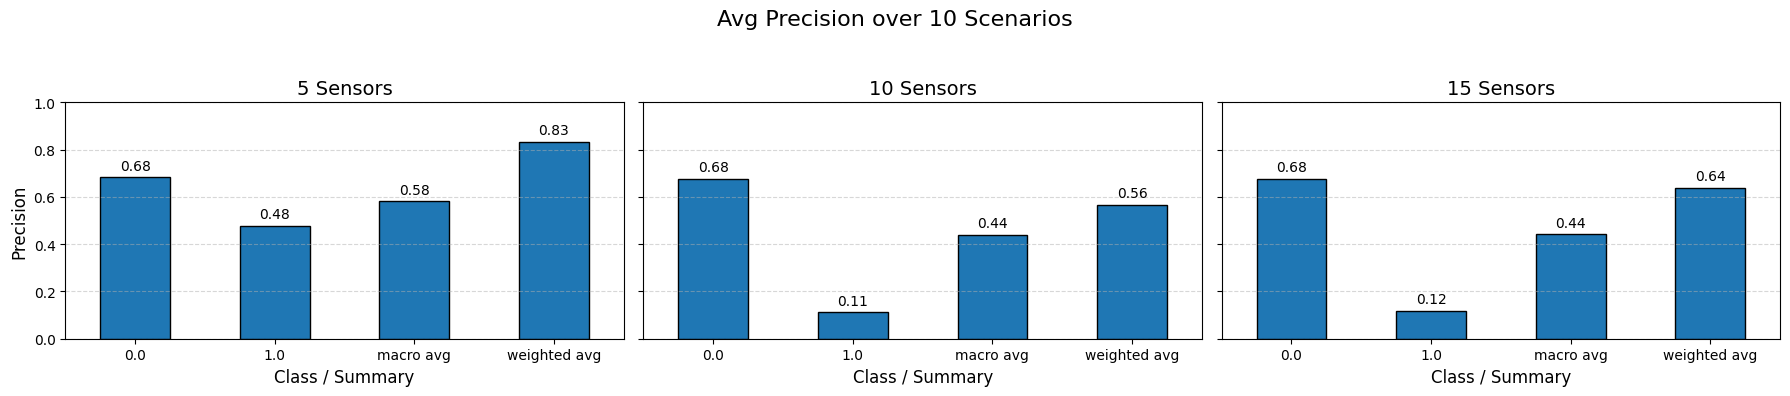

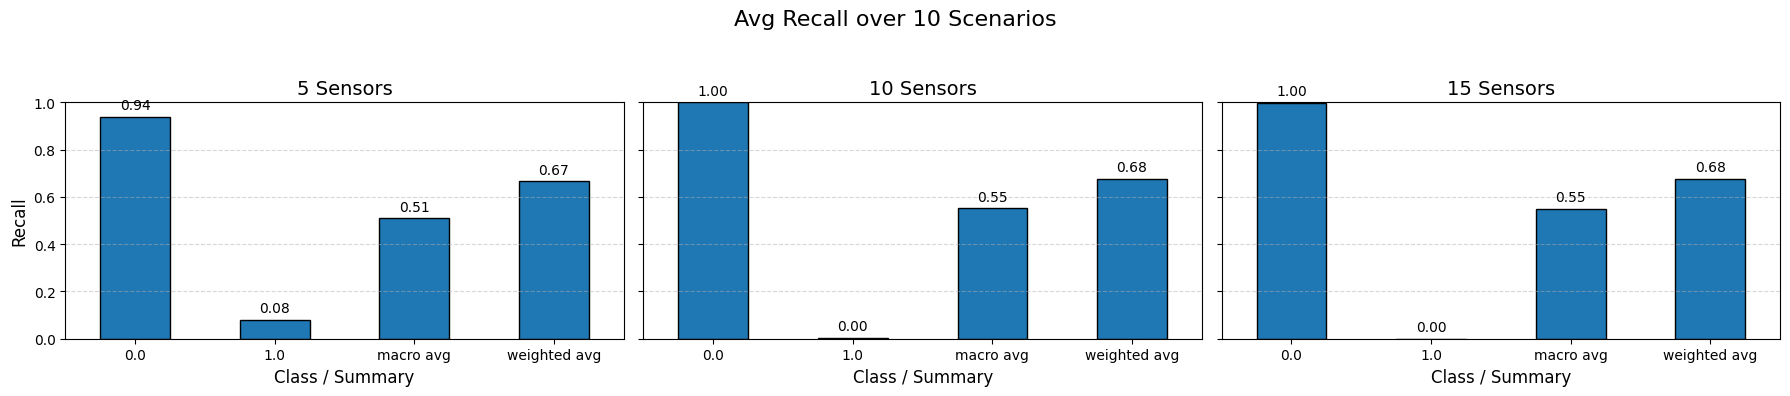

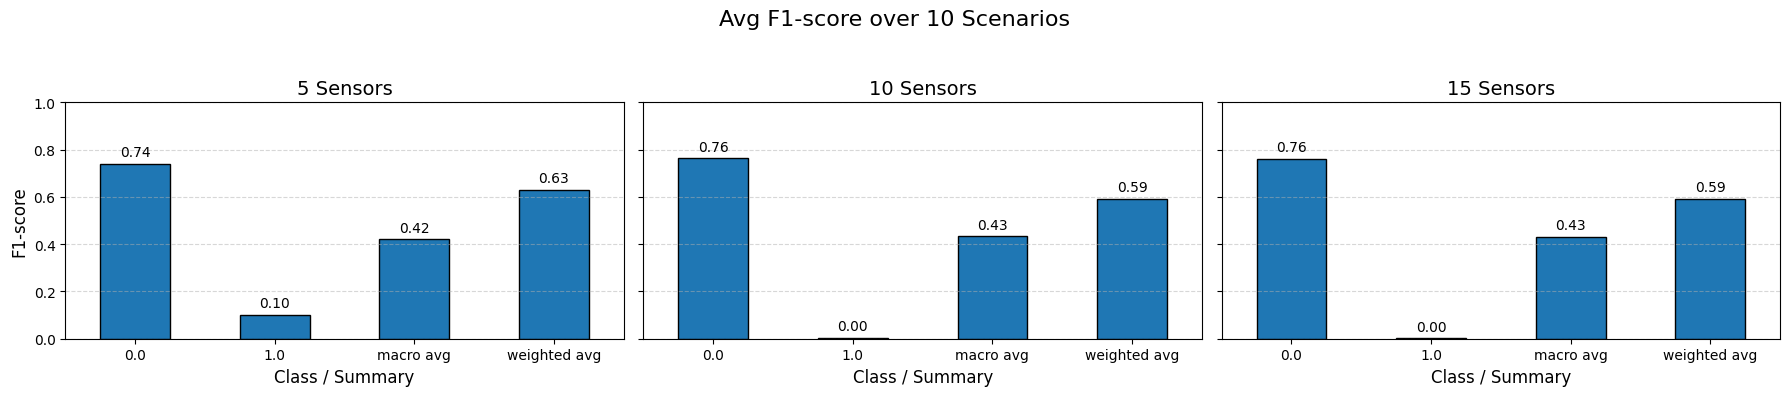

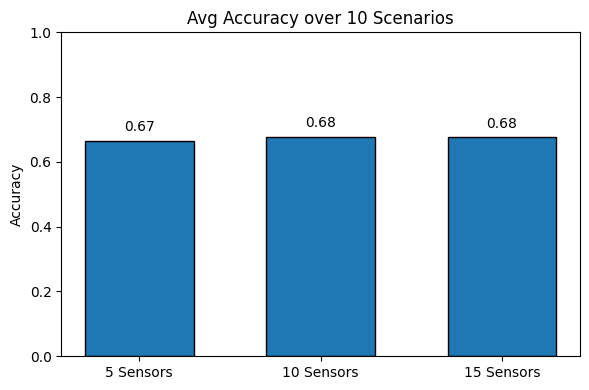

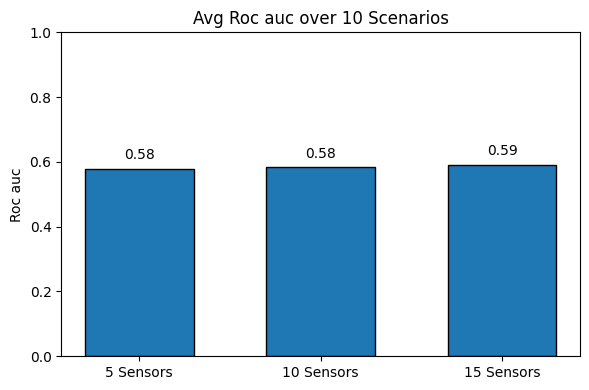

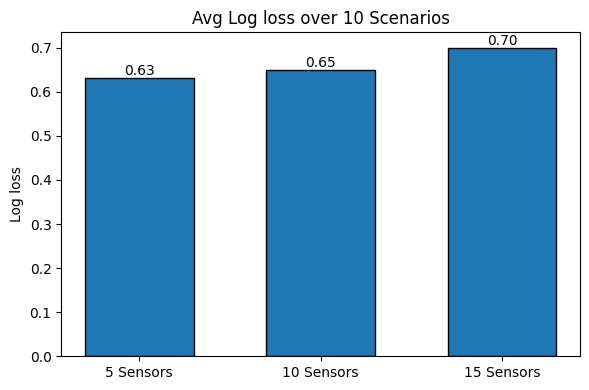

In [34]:
#Disclaimer: Graphs generated using ChatGPT
# —————————————————————————————————————————————————————
# 1) Per‐label metrics (precision, recall, f1‑score)
# —————————————————————————————————————————————————————
label_metrics = ['precision', 'recall', 'f1-score']
sensor_sets = [
    (df_mean_5,  '5 Sensors'),
    (df_mean_10, '10 Sensors'),
    (df_mean,    '15 Sensors'),
]

for m in label_metrics:
    fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
    fig.suptitle(f'Avg {m.capitalize()} over {len(runs_5)} Scenarios', fontsize=16)

    for ax, (dfm, label) in zip(axes, sensor_sets):
        df_plot = dfm.drop(index=[r for r in ['roc_auc','log_loss','accuracy'] if r in dfm.index])
        bars = df_plot[m].plot(
            kind='bar', ax=ax,
            edgecolor='black', linewidth=1, legend=False
        )
        ax.set_ylim(0, 1)
        ax.set_title(label, fontsize=14)
        ax.set_xlabel('Class / Summary', fontsize=12)
        if ax is axes[0]:
            ax.set_ylabel(m.capitalize(), fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        ax.set_xticklabels(df_plot.index, rotation=0, fontsize=10)

        for rect in bars.patches:
            h = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width()/2,
                h + 0.02,
                f'{h:.2f}',
                ha='center', va='bottom',
                fontsize=10
            )

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


# —————————————————————————————————————————————————————
# 2) Global metrics (accuracy, roc_auc, log_loss)
# —————————————————————————————————————————————————————
global_metrics = ['accuracy', 'roc_auc', 'log_loss']
sensor_labels  = ['5 Sensors', '10 Sensors', '15 Sensors']

# gather the “precision” column for each global metric row
values = {
    'accuracy': [df_mean_5.loc['accuracy','precision'],
                 df_mean_10.loc['accuracy','precision'],
                 df_mean.loc['accuracy','precision']],
    'roc_auc':   [df_mean_5.loc['roc_auc','precision'],
                  df_mean_10.loc['roc_auc','precision'],
                  df_mean.loc['roc_auc','precision']],
    'log_loss':  [df_mean_5.loc['log_loss','precision'],
                  df_mean_10.loc['log_loss','precision'],
                  df_mean.loc['log_loss','precision']],
}

x = np.arange(len(sensor_labels))

for m in global_metrics:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(x, values[m], width=0.6, edgecolor='black')
    if m in ['accuracy','roc_auc']:
        ax.set_ylim(0, 1)
    ax.set_xticks(x)
    ax.set_xticklabels(sensor_labels)
    ax.set_ylabel(m.replace('_',' ').capitalize())
    ax.set_title(f'Avg {m.replace("_"," ").capitalize()} over {len(runs_5)} Scenarios')
    for i, v in enumerate(values[m]):
        ax.text(i, v + (0.02 if m in ['accuracy','roc_auc'] else 0),
                f'{v:.2f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()


In [ ]:
df_combined = pd.concat(
    [df_mean_5, df_mean_10, df_mean],
    axis=1,
    keys=['5 Sensors', '10 Sensors', '15 Sensors']
)

print(df_combined.to_markdown(floatfmt=".3f"))

ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

In [38]:
for scenario in scenarios.values():
    scenario.close()

## BattLeDIM

###  Loading scenarios and placing sensors

Here the BattLeDIM data for training and testing is loaded, the sensor placements are calculated and the simulations are run

In [73]:
# use scada date, because data provides the pressure data for 31 nodes, while the simulation for some reason only provides it for 29
data = load_scada_data(False)

In [ ]:
sensor_placements = calc_sensor_placement(data.get_data_pressures().T, num_sensors=len(sensor_placements))

In [ ]:
train_configs = []
train_scenarios = []
test_configs = []
test_scenarios = []
for i in range(10):
    train_configs.append(load_scenario(False))
    train_scenarios.append(ScenarioSimulator(scenario_config=train_configs[i]))
    test_configs.append(load_scenario(True))
    test_scenarios.append(ScenarioSimulator(scenario_config=test_configs[i]))


Again, the topology of the water distribution network does not change between the different scenarios. Here the general topology is inspected.

In [ ]:
# Run the simulations
scada_data_train = [train_scenarios[i].run_simulation(verbose=True) for i in range(10)]
scada_data_test = [test_scenarios[i].run_simulation(verbose=True) for i in range(10)]

### Machine learning based leakage detection

This includes again the preprocessing and fitting of the data from the simulations, as seen for LeakDB.

In [48]:
# it seems like the pressures we get from load_data
X_train_BD = np.vstack([scada_data_train[i].get_data_pressures()[:, sensor_placements] for i in range(10)])
X_test_BD = [scada_data_test[i].get_data_pressures()[:, sensor_placements] for i in range(10)]
y_train_BD = np.concatenate([time_points_to_one_hot_encoding(
    [int(t / train_configs[i].general_params["hydraulic_time_step"]) for t in train_scenarios[i].get_events_active_time_points()],
    total_length=scada_data_train[i].get_data_pressures().shape[0]) for i in range(10)])
y_test_BD = [time_points_to_one_hot_encoding(
    [int(t / test_configs[i].general_params["hydraulic_time_step"]) for t in test_scenarios[i].get_events_active_time_points()],
    total_length=scada_data_test[i].get_data_pressures().shape[0]) for i in range(10)]



In [49]:
# shuffle the data to avoid any bias, as seen in the LeakDB part
X_train_BD, y_train_BD = sklearn.utils.shuffle(
    X_train_BD, y_train_BD,
    random_state=42
)

In [ ]:
# fit the classifier to the data
mixed_clf_BD = mixed_model_classification_fit(100, X_train_BD, y_train_BD, n_jobs=8)

In [ ]:
suspicious_time_points_BD = mixed_model_classification_predict(mixed_clf, X_test_BD, y_test_BD, n_jobs=8)
train_suspicious_time_points_BD = mixed_model_classification_predict(mixed_clf, X_train_BD, y_train_BD, n_jobs=8)

In [ ]:
for time in suspicious_time_points_BD:
    if time == 1:
        print("Leakage detected at time point:", suspicious_time_points_BD.index(time))

### Evaluation

In [ ]:
for i, label in enumerate(y_test_BD):
    if label == 0:
        print("Leakage occurred at time point:", i)

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(list(range(len(y_test_BD))), y_train_BD, color="red", label="Ground truth")
colors = ['cyan'] * len(y_train_BD)
plt.bar(list(range(len(train_suspicious_time_points_BD))), train_suspicious_time_points_BD, label="Raised alarm")
plt.legend()
plt.ylabel("Leakage indicator")
plt.yticks([0, 1], ["Inactive", "Active"])
plt.xlabel("Time (5min steps)")
plt.show()

In [ ]:
for scen in train_scenarios:
    scen.close()
for scen in test_scenarios:
    scen.close()
    